<a href="https://colab.research.google.com/github/DaveMSU/Kaggle/blob/master/Clean_vs_Dirty/Solution(rus).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import random
import numpy as np
import pandas as pd
import torchvision
from torchvision import transforms, models

import PIL
from PIL import Image
import matplotlib.pyplot as plt

k = 6#6#11

random.seed(k)
np.random.seed(k)
torch.manual_seed(k)
torch.cuda.manual_seed(k)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


#  Заметил, что так как нейросеть обучаяется на небольшой выборке 
# ,то разумно будет убрать "сложные" фотографии, поэтому я решил удалить
#некоторые изоображения, другие изменить детально (для этого я 
#использовал фотошоп).


#  Убрал 14-ую чистую тарелку с рисунками (та что с синими липестками) и продублировал 
#ее 6-ой металической с подрисованным в фотошопе деформированным дном 
#(такие есть в тестовой выборвке и они часто считались грязными)
#20-1+1 = 20 - чистых.

#  Убрал 1-ую, 2-ую и 11-ую грязные тарелки 
#и продублировал "хорошие", а именно 9-ую и 13-ую тарлеки.
#20-3+1+1 = 19 - грязных.

#Что насчёт Валидации? 
#  Валидационная выборка присутствует постольку поскольку т.к. значение
#accuracy на ней не сильно коррелирует с accuracy на тестовой выборке, однако
#по loss'у так или иначе можно судить о результате на тесте, поэтому 
#ее я формировал как раз из тех фотографий, которые я убрал из train'а
#добавив некоторые из train'а до круглого числа (1+3 + 6 = 10 фотографий в валидации).

width,height = 224,224
am_val = 10
am_train = 39


#
#
#

mult = 4 #Увеличиваю выборку отражения по верт. и гориз. в 4 раза.

x_train = torch.ones(mult*am_train, 3, width, height, dtype=torch.float)
y_train = torch.ones(mult*am_train, dtype=torch.int64)

x_val = torch.ones(am_val, 3, width, height, dtype=torch.float)
y_val = torch.ones(am_val, dtype=torch.int64)


print(x_train.shape)
print(y_train.dtype,'\n')

print(x_val.shape)
print(y_val.dtype)

torch.Size([156, 3, 224, 224])
torch.int64 

torch.Size([10, 3, 224, 224])
torch.int64


In [ ]:
transform0 = transforms.Compose([
      
        transforms.RandomResizedCrop(224,(0.1,0.65)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(0,(1.7,1.8),0,0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

transform = transforms.Compose([
   
        transforms.ColorJitter(0,(1.3,1.3),(1.6,1.6),0),
        transforms.CenterCrop(224),
        transforms.RandomResizedCrop(224,(0.965,1))
  ])

transform1 = transforms.Compose([
    
        transforms.ColorJitter(0,0,(1.5,2),0),
        transforms.CenterCrop(224),
        transforms.RandomResizedCrop(224,(0.965,1)),
        transforms.RandomHorizontalFlip(1)
  ])

transform2 = transforms.Compose([
    
        transforms.CenterCrop(224),
        transforms.RandomResizedCrop(224,(0.956,1)),
        transforms.RandomVerticalFlip(1)
  ])

transform3 = transforms.Compose([
    
        transforms.CenterCrop(224),
        transforms.RandomResizedCrop(224,(0.956,1)),
        transforms.RandomVerticalFlip(1),
        transforms.RandomHorizontalFlip(1)
  ])

transformTT = transforms.Compose([
    
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])


#  Формирую маску по которой буду вырезать из фотографии окружность, замостив
#остальную часть фотографии шумом.

mask = np.ones([224,224,3])
w, h = 224,224


#  Ранее вырезал окружность в центре изображения, но предположил, что сместив
#ее центр к краям результат улучшиться в силу следующих предположений:
# 1.Мат. ожидание центров тарелок врядkи находятся в центре изоображения.
# 2.Находящиеся в центре изображения тарелки при данных оперциях (вырезке окружности и 
#отражении фото) приводят к тому, что в выделенную окружностью область попадают
#разные части тарелки, что конечно же делает разнообразнее тренировочную выборку.

Ox = -(w/2)*0.1
Oy = (h/2)*0.1
r = 0.87#0.87

for i in range(w):
  for j in range(h):
    rand = random.randint(-150, 150)
    if( ((i-w/2 + Ox)**2 + (j-h/2 + Oy)**2)**(1/2) > r*w/2 ):

      mask[i,j,0] = rand * 2
      mask[i,j,1] = rand * 2
      mask[i,j,2] = rand * 2

      if (mask[i,j,0] < 0):
        mask[i,j,0] = 0

      if (mask[i,j,1] < 0):
        mask[i,j,1] = 0

      if (mask[i,j,2] < 0):
        mask[i,j,2] = 0

      if (mask[i,j,0] > 255):
        mask[i,j,0] = 255

      if (mask[i,j,1] > 255):
        mask[i,j,1] = 255

      if (mask[i,j,2] > 255):
        mask[i,j,2] = 255
        
def cut_circle(img):
   
      w, h = 224,224
      im = np.array(img)
      for i in range(w):
        for j in range(h):
          if( ((i-w/2 + Ox)**2 + (j-h/2 + Oy)**2)**(1/2) > r*w/2 ):
            im[i,j] = mask[i,j]
              
      img = PIL.Image.fromarray(im)        
      
      return img
    
def make(str, img):
    

      im = np.array(img)
      w,h = img.size
    
      if( str == 'blue' ):
        im[:,:,0] = im[:,:,0] / 1.5
        im[:,:,1] = im[:,:,1] / 1.5 
        im[:,:,2] = im[:,:,2] 
      
      if( str == 'purple' ):
        im[:,:,0] = im[:,:,0] / 1.5
        im[:,:,1] = im[:,:,1] / 2
        im[:,:,2] = im[:,:,2] / 1.3
        
      if( str == 'yellow' ):
        im[:,:,2] = 0
   
      img = PIL.Image.fromarray(im)        
      
      return img

In [ ]:
#Тренировочный dataset:

for i in range(0,19):
  img = Image.open( "di (" + str(i+1) + ").jpg" )
  img.load()
  
  im = transform(img)
  im = cut_circle(im)
  x_train[mult*i,:,:,:] = transformTT(im)
  y_train[mult*i] = 0
  
  
  im = transform(img)
  im = transform1(im)
  im = cut_circle(im)
  x_train[mult*i+1,:,:,:] = transformTT(im)
  y_train[mult*i+1] = 0  
  

  im = transform(img)
  im = transform2(im)
  im = cut_circle(im)
  x_train[mult*i+2,:,:,:] = transformTT(im)
  y_train[mult*i+2] = 0 
  
  
  im = transform(img)
  im = transform3(im)
  im = cut_circle(im)
  x_train[mult*i+3,:,:,:] = transformTT(im)
  y_train[mult*i+3] = 0   
  
  
for i in range(19,39):
  img = Image.open( "cln (" + str(i+1 - 19) + ").jpg" )
  img.load()
  
  im = transform(img)
  im = cut_circle(im)
  x_train[mult*i,:,:,:] = transformTT(im)
  y_train[mult*i] = 1
  
  
  im = transform(img)
  im = transform1(im)
  im = cut_circle(im)
  x_train[mult*i+1,:,:,:] = transformTT(im)
  y_train[mult*i+1] = 1  
  

  im = transform(img)
  im = transform2(im)
  im = cut_circle(im)
  x_train[mult*i+2,:,:,:] = transformTT(im)
  y_train[mult*i+2] = 1 
  
  
  im = transform(img)
  im = transform3(im)
  im = cut_circle(im)
  x_train[mult*i+3,:,:,:] = transformTT(im)
  y_train[mult*i+3] = 1


print(x_train.shape)
print(y_train.shape)

torch.Size([156, 3, 224, 224])
torch.Size([156])


In [ ]:
#Валидационный dataset:

v_m = 1

for i in range(0,5):
  img = Image.open( "dr (" + str(i+1) + ").jpg" )
  img.load()
  
  im = transform(img)
  im = cut_circle(im)
  x_val[v_m*i,:,:,:] = transformTT(im)
  y_val[v_m*i] = 0
  
  
for i in range(5,10):
  img = Image.open( "cl (" + str(i+1-5) + ").jpg" )
  img.load()
  
  im = transform(img)
  im = cut_circle(im)
  x_val[v_m*i,:,:,:] = transformTT(im)
  y_val[v_m*i] = 1
  
    
print(x_val.shape)
print(y_val.shape)

torch.Size([10, 3, 224, 224])
torch.Size([10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


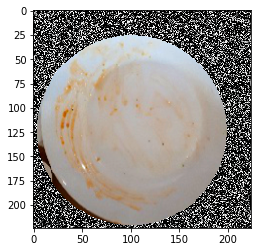

tensor(0)


In [ ]:
#Тренировочный датасет:

photo_num = 3#39*4
plt.imshow(x_train.permute(0,2,3,1)[photo_num,:,:,:].numpy() * std + mean)
plt.show()
print(y_train[photo_num])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


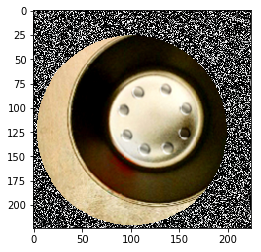

tensor(1, device='cuda:0')


In [ ]:
#Валидационный датасет:

photo_num = 9

x_val = x_val.to('cpu')
y_val = y_val.to(device)

plt.imshow(x_val.permute(0,2,3,1)[photo_num,:,:,:].numpy() * std + mean)
plt.show()
print(y_val[photo_num])

In [ ]:
#Перемешивание датасетов:

order_train = np.random.permutation(len(x_train))
order_val = np.random.permutation(len(x_val))


x_train = x_train[order_train]
y_train = y_train[order_train]

x_val = x_val[order_val]
y_val = y_val[order_val]


print(order_val)

print(x_train.shape)
print(x_val.shape)


#ОБУЧЕНИЕ:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
  param.require_grad = False
  
model.fc = torch.nn.Linear(model.fc.in_features,2)
  

[4 6 2 1 8 3 0 5 9 7]
torch.Size([156, 3, 224, 224])
torch.Size([10, 3, 224, 224])


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.0e-3, weight_decay=0.001)

In [ ]:
model.eval()

#156 нацело не дел-ся на 7, однако такой размер батча привел к лучшему результату.
batch_size = am_train*mult//7#am_train = 39

x_val = x_val.to(device)
y_val = y_val.to(device)

test_loss_history = []
test_accuracy_history = []

test_preds = model.forward(x_val)
test_accuracy = (test_preds.argmax(dim=1) == y_val).float().mean().data.cpu()

print(test_accuracy)

for epoch in range(60):
  
    model.train()
    
    order = np.random.permutation(len(x_train))
    for start_index in range(0, len(x_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = x_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
       
        preds = model.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
    #        
    model.eval()
    
    test_preds = model.forward(x_val)
    test_loss = loss(test_preds, y_val).data.cpu()
    test_accuracy = (test_preds.argmax(dim=1) == y_val).float().mean().data.cpu()
    
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)
    
    print(test_accuracy, '  ', test_loss, '   epoch:', epoch+1 )
    
    #Пометка. Случай в котором есть смысл остановить обучение и проверить результат на Kaggle.
    if(loss(test_preds, y_val).data.cpu() < 0.235):
      break


tensor(0.5000)
tensor(0.6000)    tensor(0.8908)    epoch: 1
tensor(0.7000)    tensor(0.6573)    epoch: 2
tensor(0.6000)    tensor(0.6565)    epoch: 3
tensor(0.9000)    tensor(0.5495)    epoch: 4
tensor(0.9000)    tensor(0.5073)    epoch: 5
tensor(0.9000)    tensor(0.4823)    epoch: 6
tensor(0.9000)    tensor(0.4620)    epoch: 7
tensor(0.9000)    tensor(0.4119)    epoch: 8
tensor(0.9000)    tensor(0.4005)    epoch: 9
tensor(0.9000)    tensor(0.4190)    epoch: 10
tensor(0.9000)    tensor(0.4394)    epoch: 11
tensor(0.9000)    tensor(0.4587)    epoch: 12
tensor(0.9000)    tensor(0.3856)    epoch: 13
tensor(0.9000)    tensor(0.3704)    epoch: 14
tensor(0.9000)    tensor(0.3824)    epoch: 15
tensor(0.9000)    tensor(0.3604)    epoch: 16
tensor(0.8000)    tensor(0.4709)    epoch: 17
tensor(0.8000)    tensor(0.4353)    epoch: 18
tensor(0.8000)    tensor(0.4115)    epoch: 19
tensor(0.9000)    tensor(0.3933)    epoch: 20
tensor(0.9000)    tensor(0.3701)    epoch: 21
tensor(0.9000)    tensor(0.4

In [ ]:
#test_accuracy_history_wd_0 = test_accuracy_history
#test_loss_history_wd_0 = test_loss_history

#test_accuracy_history_wd_01 = test_accuracy_history
#test_loss_history_wd_01 = test_loss_history

#test_accuracy_history_wd_05 = test_accuracy_history
#test_loss_history_wd_05 = test_loss_history

#test_accuracy_history_wd_1 = test_accuracy_history
#test_loss_history_wd_1 = test_loss_history

test_accuracy_history_wd_2 = test_accuracy_history
test_loss_history_wd_2 = test_loss_history

Text(0.5, 1.0, 'Validation accuracy.')

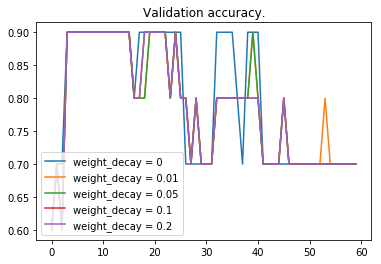

In [ ]:
plt.plot(test_accuracy_history_wd_0, label='weight_decay = 0')
plt.plot(test_accuracy_history_wd_01, label='weight_decay = 0.01')
plt.plot(test_accuracy_history_wd_05, label='weight_decay = 0.05')
plt.plot(test_accuracy_history_wd_1, label='weight_decay = 0.1')
plt.plot(test_accuracy_history_wd_2, label='weight_decay = 0.2')
plt.legend()
plt.title('Validation accuracy.')

Text(0.5, 1.0, 'Validation loss.')

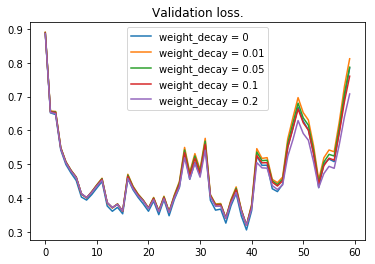

In [ ]:
plt.plot(test_loss_history_wd_0, label='weight_decay = 0')
plt.plot(test_loss_history_wd_01, label='weight_decay = 0.01')
plt.plot(test_loss_history_wd_05, label='weight_decay = 0.05')
plt.plot(test_loss_history_wd_1, label='weight_decay = 0.1')
plt.plot(test_loss_history_wd_2, label='weight_decay = 0.2')
plt.legend()
plt.title('Validation loss.')

In [ ]:
#Скрипт для просмотра не определившихся тарелок на валидации:

photo_num = 5
preds = model.forward(x_val.to(device))
x_val = x_val.to('cpu')
y_val = y_val.to(device)

plt.imshow(x_val.permute(0,2,3,1)[photo_num,:,:,:].numpy() * std + mean)
plt.show()

print(y_val[photo_num])
print(torch.nn.functional.softmax(preds, dim=1)[photo_num])

for i in range(len(x_val)):
  if(preds.argmax(dim=1)[i] != y_val[i]):
    print(i, end = ' ')
  else:
    print(1, end = ' ')
    
print()

In [ ]:
#Тестовый dataset:

x_test = torch.ones(744, 3, width, height, dtype=torch.float)
y_test = torch.ones(744, dtype=torch.float)

for i in range(744):
  img = Image.open( "test (" + str(i+1) + ").jpg" )
  img.load() 
  im = transform(img)
  im = cut_circle(im)
  x_test[i,:,:,:] = transformTT(im)
  
print(x_test.shape)

torch.Size([744, 3, 224, 224])


In [ ]:
#Пропуск тестовой выборки через нейрость и формирование списка.

test_predictions = []
test_img_paths = []

for i in range(744):
  if(i<10):
    test_img_paths.append("000" + str(i))
  if(9<i<100):
    test_img_paths.append("00" + str(i))
  if(99<i<1000):
    test_img_paths.append("0" + str(i))

model.eval()
    
for i in range(744):
  
  
  preds = model.forward(x_test[i,:,:,:].unsqueeze(0).to(device))
  test_predictions.append(
    torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())  

  
#Вывожу результаты, чтобы далее регулировать threshold.

for i in range(743,-1,-1):
  print(test_predictions[i], '  #', i+1)

[0.81394947]   # 744
[0.8166862]   # 743
[0.92398924]   # 742
[0.04038334]   # 741
[0.09520935]   # 740
[0.08698228]   # 739
[0.9803577]   # 738
[0.3447666]   # 737
[0.60529757]   # 736
[0.00518763]   # 735
[0.05660637]   # 734
[0.27917817]   # 733
[0.98843]   # 732
[0.03126108]   # 731
[0.0541517]   # 730
[0.14567159]   # 729
[0.8980555]   # 728
[0.9577087]   # 727
[0.01658349]   # 726
[0.34816733]   # 725
[0.02092105]   # 724
[0.98783314]   # 723
[0.12845117]   # 722
[0.9789291]   # 721
[0.00817557]   # 720
[0.10548685]   # 719
[0.7066892]   # 718
[0.8450186]   # 717
[0.24035932]   # 716
[0.89948523]   # 715
[0.27099472]   # 714
[0.04774998]   # 713
[0.08881687]   # 712
[0.15267698]   # 711
[0.186316]   # 710
[0.42506677]   # 709
[0.03685922]   # 708
[0.06279892]   # 707
[0.6802526]   # 706
[0.93908787]   # 705
[0.08191959]   # 704
[0.5078616]   # 703
[0.8502063]   # 702
[0.7438007]   # 701
[0.12736739]   # 700
[0.08079012]   # 699
[0.3444194]   # 698
[0.0384165]   # 697
[0.07631791]

In [ ]:
#Формирование конечного .csv файла:

submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

#значение порога всегда разное, иногда его стоит уменьшать, а иногда увеличивать. Однако лучший результат показало при значении порога 0.78
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred < 0.4 else 'cleaned')
submission_df.set_index('id', inplace=True)
submission_df.to_csv('submission.csv')

from google.colab import files
files.download('submission.csv')

submission_df.head(n=5) 

,label
id,
0000,dirty
0001,dirty
0002,cleaned
0003,dirty
0004,dirty
